# Adversarial examples (0.2 балла)

В этом разделе мы будем создавать adversarial примеры для типичной архитектуры сетей. Для начала нужно сделать простую сверточную сеть для классификации (2-3 слоя) и обучить ее до нормального качества (>98%). Для экономии времени не нужно обучать ее слишком много эпох как мы это делали ранее.

*Упражнение.* Можете попробовать дома обучить сеть до сходимости и сравнить, какой из вариантов более уязвим к таким атакам.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.datasets as dsets
# import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(      # input 1, 28, 28
            nn.Conv2d(
                in_channels=1,              
                out_channels=4,            
                kernel_size=5              
            ),                              
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=4,
                out_channels=16,
                kernel_size=5
            ),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        x = self.features(x.view(-1, 1, 28, 28))
        out = self.classifier(x.view(-1, 4 * 4 * 16))
        return F.log_softmax(out, dim=-1)

In [5]:
from tqdm import trange

        
def train_epoch(model, optimizer, device='cpu', batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        data = x_batch.to(device)
        target = y_batch.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1]
        pred = pred.to(device)
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, device='cpu'):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):  
        data = x_batch.to(device)
        target = y_batch.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].to(device)
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc.cpu())
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, device='cpu'):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, device=device, batchsize=batchsize)

        val_loss, val_acc = test(model, device)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

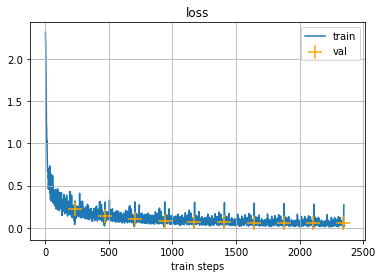

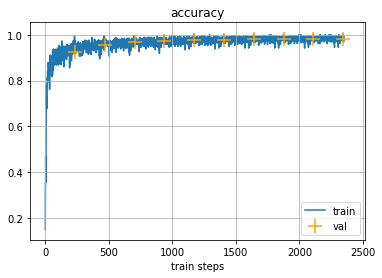

Final error: 1.84%
CPU times: user 14min 3s, sys: 8.35 s, total: 14min 11s
Wall time: 2min 13s


In [6]:
%%time

model = ConvNet().to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 10, device)
model.cpu()

Теперь возьмем несколько изображений, которые мы будем пытаться искажать.

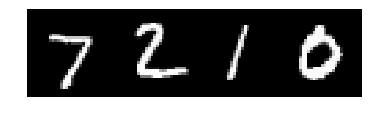

[7 2 1 0]


In [7]:
import torchvision

inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]

def imshow(images):
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(inputs)
print(labels.numpy())

Реализуйте простой способ adversarial-атаки: сделайте шаг градиентного подъема по входам (изображениям) для увеличения ошибки классификации. Подберите шаг, чтобы значения предсказания уже начинали меняться, но визуально цифра мало менялась (т.е. вы бы по-прежнему ее распознали как ту же цифру с высокой уверенностью).

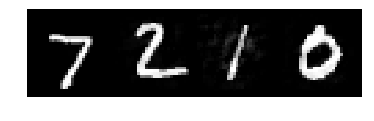

In [8]:
from copy import deepcopy

def corrupt_simple(inputs, labels, model, weight):
    # YOUR CODE HERE
    
    corr_inputs = inputs.requires_grad_(True)
    model.zero_grad()
    
    outs = model(corr_inputs)
    loss = F.nll_loss(outs, labels)
    loss.backward()
        
    corr_inputs = torch.clamp(corr_inputs + weight * corr_inputs.grad, 0, 1)
    
    return corr_inputs

corrupted_inputs = corrupt_simple(inputs, labels, model, 1500)
imshow(corrupted_inputs.data)

In [9]:
# test_net = ConvNet()
# test_dict = torch.load('net_weights.pth')

# test_net.load_state_dict(test_dict)

# corrupted_inputs_test = corrupt_simple(inputs, labels, test_net, 50)

# corrupted_inputs_test

# outputs_ = test_net(corrupted_inputs_test)
# outputs_

# golden_array = torch.load('test_array_step.pth')
# print(golden_array)

# assert np.allclose(outputs_.detach().numpy(), golden_array) "Check your corrupt_simple function"

In [10]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 2 1 0]


Видно, что в таком подходе приходится уже сильно исказить изображение, чтобы ответы начали меняться. Если вместо градиента использовать только его знак (по каждой координате), то результаты получаются лучше. Реализуйте такой метод.

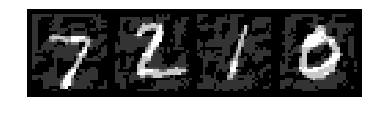

In [11]:
def corrupt_sign(inputs, labels, model, weight):
    # YOUR CODE HERE
    corr_inputs = inputs.requires_grad_(True)
    criterion = nn.CrossEntropyLoss()
    model.zero_grad()
    
    outs = model(corr_inputs)
    loss = criterion(outs, labels)
    loss.backward()
        
    corr_inputs = torch.clamp(corr_inputs + weight * torch.sign(corr_inputs.grad), 0, 1)
    
    return corr_inputs
    
corrupted_inputs = corrupt_sign(inputs, labels, model, 0.2)
imshow(corrupted_inputs.data) 

In [12]:
# test_net = ConvNet()
# test_dict = torch.load('net_weights.pth')
# test_net.load_state_dict(test_dict)

# corrupted_inputs_test = corrupt_sign(inputs, labels, test_net, 0.2)
# outputs_ = test_net(corrupted_inputs_test)

# golden_array = torch.load('test_array_sign.pth')
# assert np.allclose(outputs_.detach().numpy(), golden_array), "Check your corrupt_sign function"

In [13]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[9 1 8 9]


Теперь посмотрим как сильно меняется точность на всей выборке.

In [14]:
def evaluate_network_attack(net, corrupt_function, weight):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in test_loader:
        images, labels = data
        images = corrupt_function(images, labels, net, weight)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy %d %% \n' % (100. * sum(class_correct) / sum(class_total)))
        
    for i in range(10):
        print('Accuracy of %2s : %2d %%' % (
              i, 100. * class_correct[i] / class_total[i]))

In [15]:
evaluate_network_attack(model, corrupt_simple, 200)

Accuracy 1 % 

Accuracy of  0 : 13 %
Accuracy of  1 :  3 %
Accuracy of  2 :  3 %
Accuracy of  3 : 13 %
Accuracy of  4 :  2 %
Accuracy of  5 : 13 %
Accuracy of  6 :  1 %
Accuracy of  7 :  8 %
Accuracy of  8 :  8 %
Accuracy of  9 :  2 %


In [16]:
evaluate_network_attack(model, corrupt_sign, 0.2)

Accuracy 0 % 

Accuracy of  0 : 14 %
Accuracy of  1 : 11 %
Accuracy of  2 : 13 %
Accuracy of  3 :  0 %
Accuracy of  4 : 11 %
Accuracy of  5 : 10 %
Accuracy of  6 : 14 %
Accuracy of  7 :  6 %
Accuracy of  8 : 14 %
Accuracy of  9 :  4 %


# Adversarial networks (0.8 балла)

На этом семинаре мы поработаем с adversarial-архитектурами. Мы не будем обучать полноценную генеративную модель (GAN), так как это потребует много времени, а вместо этого вернемся к задаче повышения разрешения изображений и попробуем улучшить нашу модель с помощью advesarial-подхода (получится упрощенный SRGAN).

Как мы обсуждали ранее, MSE хоть и является простой и удобной метрикой, она плохо отражает визуальные характеристики изображений. Поэтому мы добавим дискриминатор, который будет пытаться отличить изображения высокого качества от наших результатов, и в модели повышающей разрешение будем пытаться его обмануть.

Если это записать строго, то у нас будут две сети: $D$ - дискриминатор и $E$ - сеть, повышающая разрешение, и оптимизировать мы для них будем следующие целевые функции соответсвенно:

$$
    \min_D \bigl[ \mathrm{BCE}(D(E(x_l)), 0) + \mathrm{BCE}(D(x_h), 1) \bigr],
$$

$$
    \min_E \bigl[ \| E(x_l) - x_h \|_2^2 - \lambda \cdot \mathrm{BCE}(D(E(x_l)), 0) \bigr],
$$

где $BCE(l, y)$ - бинарная кросс-энтропия между ответами $l$ и метками $y$, $x_l$ - изображения низкого качества, $x_h$ - изображения высокого качества.

*Упражнение.* Почему в целевой функции для $D$ нет компоненты $\mathrm{BCE}(D(x_h), 1)$?

Для начала продублируем код с позапрошлого семинара, чтобы у нас была сеть для сравнения. Используйте архитектуру с двумя сверточными слоями для простоты.

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [18]:
class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, 7, 1, 3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 10, 7, 1, 3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 1, 3, 1, 1)
        )

    def forward(self, input):
        output = self.cnn(input)
        return output + input

In [19]:
srcnn = SuperResolutionNetwork()

In [20]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for _, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        data = low_res_and_high_res(x_batch)
        target = x_batch
        optimizer.zero_grad()
        output = model(data)        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.cpu().item()
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        x_batch = x_batch.float()
        data = low_res_and_high_res(x_batch)
        target = x_batch
        output = model(data)
        loss = F.mse_loss(output, target)        
        loss = loss.data.cpu().item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

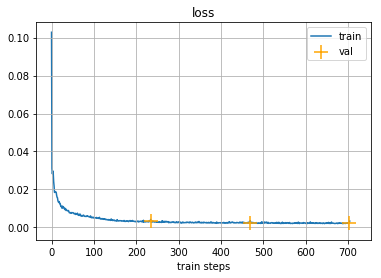

CPU times: user 25min 49s, sys: 36.7 s, total: 26min 26s
Wall time: 3min 56s


In [21]:
%%time 

opt = torch.optim.Adam(srcnn.parameters(), lr=0.005)
train(srcnn, opt, 3)

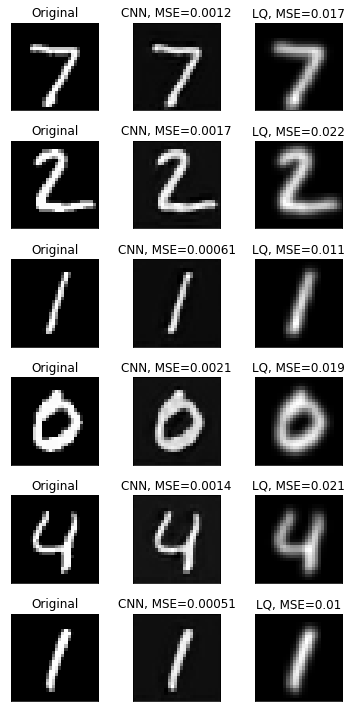

In [22]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(test_images_blurred)

examplesCount = 6
plt.figure(figsize=[5, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 3, i * 3 + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 2)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("CNN, MSE={:.2}".format(mse))
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 3)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2}".format(mse))
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

Теперь переходим к adversarial модели. Создайте простую сеть (2-3 слоя) для бинарной классификации изображений.

In [23]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self, channels=1):
        self.in_channels=channels
        super().__init__()
        self.features = nn.Sequential( 
            nn.Conv2d(self.in_channels, 4, 5),                              
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 16, 5),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Linear(4 * 4 * 16, 2)
        
    def forward(self, x):
        x = self.features(x.view(-1, 1, 28, 28))
        out = self.classifier(x.view(-1, 4 * 4 * 16))
        return F.log_softmax(out, dim=-1)

In [24]:
srgan = SuperResolutionNetwork()
disc = DiscriminatorNetwork()

При оптимизации adversarial-архитектур возникает дополнительная сложность - сети необходимо оптимизировать поочередно. Иногда для них приходится подбирать оптимальное соотношение числа шагов, но мы ограничимся вариантом 1:1. Допишите недостающий код оптимизации ниже.

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [26]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result


DISC_LOSS_WEIGHT = 0.1

def losses(model, disc, x_batch):
    data = low_res_and_high_res(x_batch)
    target = x_batch
    output = model(data)
    
    criterion = nn.CrossEntropyLoss()
    # YOUR CODE
    disc_real = disc(target)
    disc_fake = disc(output)
    is_true = torch.ones(data.shape[0]).long()
    is_false = 1 - is_true
    
    disc_loss = (criterion(disc_fake, is_false) + criterion(disc_real, is_true))
    model_loss = nn.MSELoss()(output, target) - DISC_LOSS_WEIGHT * disc_loss 
    
    return disc_loss, model_loss
    

def train_epoch(model, disc, m_opt, d_opt, batchsize=32):
    d_loss_log = []
    m_loss_log = []
    model.train()
    for batch_num, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        d_loss, m_loss = losses(model, disc, x_batch)
            
        # YOUR CODE
        if batch_num % 2 == 0:
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
        else:
            m_opt.zero_grad()
            m_loss.backward()
            m_opt.step()
        
        d_loss_log.append(d_loss.item())
        m_loss_log.append(m_loss.item())
    return d_loss_log, m_loss_log 

def test(model, disc):
    d_loss_log = []
    m_loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        d_loss, m_loss = losses(model, disc, x_batch)
        d_loss_log.append(d_loss.item())
        m_loss_log.append(m_loss.item())
    return d_loss_log, m_loss_log 

def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_history[0], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Discriminator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history[1], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 2], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Model loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()
    
def train(model, disc, m_opt, d_opt, n_epochs):
    train_log = [[], []]
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, disc, m_opt, d_opt, batchsize=batch_size)
        val_loss = test(model, disc)
        train_log[0].extend(train_loss[0])
        train_log[1].extend(train_loss[1])
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss[0]), np.mean(val_loss[1])))
        clear_output()
        plot_history(train_log, val_log)    

Теперь запустим оптимизацию. Большая проблема при работе с adversarial-моделями - в том, что по графикам оптимизации мало чего понятно. То есть по ним можно увидеть какое-то совсем плохое поведение и, возможно, найти ошибки в коде, но вот понять, дообучилась ли сеть, или ее еще стоит пообучать, часто нельзя. Обычно все метрики просто колеблются вокруг константы, но при этом сеть обучается (по очереди происходит небольшое улучшение дискриминатора, а потом оно тут же убирается основной сетью).

Обучите сеть на 2-3 эпохах и добейтесь, чтобы влияние adversarial-потерь было заметно (на примерах ниже). Для этого потребуется, чтобы качество дискриминатора не ушло совсем в 0. Возможно, придется немного поиграться с параметрами.

Потом дома можно оставить обучение на 5-10 эпох и увидеть изменения в качестве.

Также обратите внимание, что MSE для adversarial-архитектуры выходит хуже, чем обычной. Но мы так и планировали сделать - ведь MSE плохо оценивает визуальное качество.

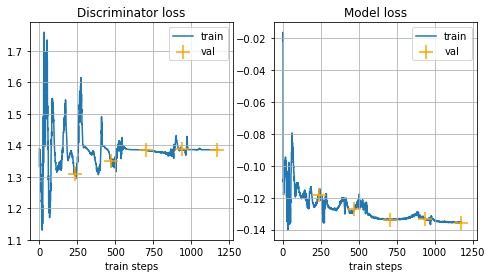

CPU times: user 45min 50s, sys: 3.05 s, total: 45min 53s
Wall time: 6min 58s


In [27]:
%%time

m_opt = torch.optim.Adam(srgan.parameters(), lr=0.005)
d_opt = torch.optim.Adam(disc.parameters(), lr=0.005)
train(srgan, disc, m_opt, d_opt, 5)

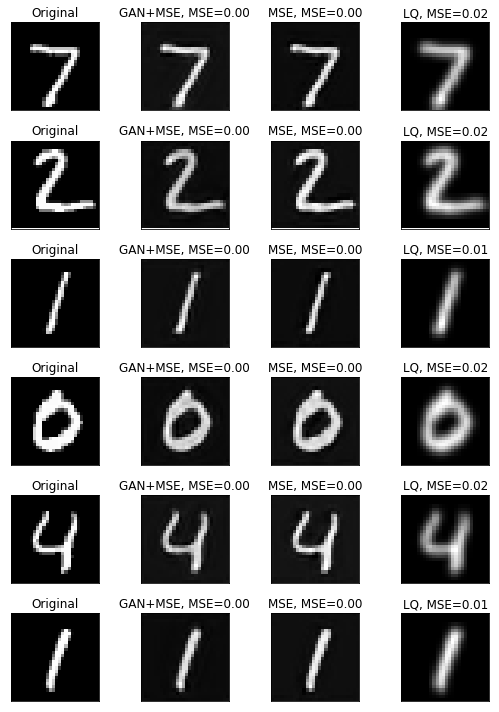

In [28]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(test_images_blurred)
result_gan = srgan(test_images_blurred)

examplesCount = 6
rows, cols = examplesCount, 4
plt.figure(figsize=[7, 10])
for i in range(examplesCount):
    plt.subplot(rows, cols, i * cols + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 2)
    mse = np.mean((test_images[i].numpy() - result_gan[i].data.numpy())**2)
    plt.title("GAN+MSE, MSE={:.2f}".format(mse))
    plt.imshow(result_gan[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 3)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("MSE, MSE={:.2f}".format(mse))
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 4)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2f}".format(mse))
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()